In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('/content/parkingLot (1).csv')
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%d-%m-%Y %H:%M', dayfirst=True)

entry_data = data[data['camera_id'] == 1].copy()
exit_data = data[data['camera_id'] == 2].copy()

entry_data = entry_data.rename(columns={'timestamp': 'entry_time'})
exit_data = exit_data.rename(columns={'timestamp': 'exit_time'})

merged_data = pd.merge(entry_data, exit_data, on='vehicle_no', how='inner')
merged_data['time_spent'] = (merged_data['exit_time'] - merged_data['entry_time']).dt.total_seconds() / 60
merged_data = merged_data[(merged_data['time_spent'] > 0) & (merged_data['time_spent'] <= 24 * 60)]
merged_data['date'] = merged_data['entry_time'].dt.date

daily_counts = data[data['camera_id'] == 1].groupby(data['timestamp'].dt.date).size()
daily_avg_time = merged_data.groupby('date')['time_spent'].mean()

In [13]:
#Rolling Statistics Imputation
rolling_mean_counts = daily_counts.rolling(window=3, min_periods=1).mean()
rolling_mean_time = daily_avg_time.rolling(window=3, min_periods=1).mean()

#Mean Imputation
daily_counts_mean = daily_counts.fillna(daily_counts.mean())
daily_avg_time_mean = daily_avg_time.fillna(daily_avg_time.mean())

train_size = int(0.8 * len(daily_counts))

train_counts_rm, test_counts_rm = rolling_mean_counts[:train_size], rolling_mean_counts[train_size:]
train_time_rm, test_time_rm = rolling_mean_time[:train_size], rolling_mean_time[train_size:]

train_counts_mean, test_counts_mean = daily_counts_mean[:train_size], daily_counts_mean[train_size:]
train_time_mean, test_time_mean = daily_avg_time_mean[:train_size], daily_avg_time_mean[train_size:]


In [14]:
def fit_sarimax(train_series, test_series, order, seasonal_order):
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test_series))
    return forecast, model_fit

In [15]:
results = {}
strategies = {'Rolling Mean': (train_counts_rm, test_counts_rm, train_time_rm, test_time_rm),
    'Mean Imputation': (train_counts_mean, test_counts_mean, train_time_mean, test_time_mean)
}

for strategy, (train_counts, test_counts, train_time, test_time) in strategies.items():
    forecast_counts, _ = fit_sarimax(train_counts, test_counts, order=(1, 1, 1), seasonal_order=(1, 1, 0, 7))
    forecast_time, _ = fit_sarimax(train_time, test_time, order=(1, 1, 1), seasonal_order=(1, 1, 0, 7))

    mape_counts = mean_absolute_percentage_error(test_counts, forecast_counts)
    mape_time = mean_absolute_percentage_error(test_time, forecast_time)

    results[strategy] = {
        'MAPE Counts': mape_counts,
        'MAPE Time': mape_time,
        'Forecast Counts': forecast_counts,
        'Forecast Time': forecast_time,
        'Test Counts': test_counts,
        'Test Time': test_time
    }
for strategy, metrics in results.items():
    print(f"\n{strategy}:")
    print(f"MAPE for Vehicle Counts Forecast: {metrics['MAPE Counts']:.2f}")
    print(f"MAPE for Average Time Spent Forecast: {metrics['MAPE Time']:.2f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat


Rolling Mean:
MAPE for Vehicle Counts Forecast: 0.05
MAPE for Average Time Spent Forecast: 0.83

Mean Imputation:
MAPE for Vehicle Counts Forecast: 0.07
MAPE for Average Time Spent Forecast: 0.67


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


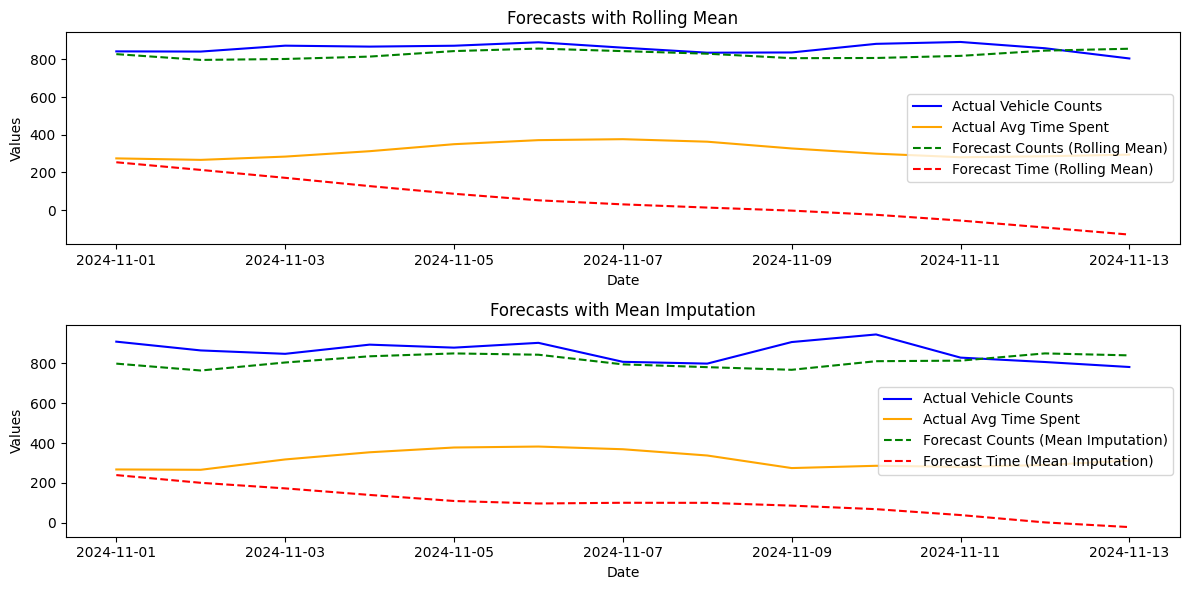

In [16]:
plt.figure(figsize=(12, 6))
for i, (strategy, metrics) in enumerate(results.items(), 1):
    plt.subplot(2, 1, i)
    plt.plot(metrics['Test Counts'].index, metrics['Test Counts'], label='Actual Vehicle Counts', color='blue')
    plt.plot(metrics['Test Time'].index, metrics['Test Time'], label='Actual Avg Time Spent', color='orange')
    plt.plot(metrics['Test Counts'].index, metrics['Forecast Counts'], linestyle='--', label=f'Forecast Counts ({strategy})', color='green')
    plt.plot(metrics['Test Time'].index, metrics['Forecast Time'], linestyle='--', label=f'Forecast Time ({strategy})', color='red')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f'Forecasts with {strategy}')
plt.tight_layout()
plt.show()